In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [2]:
house_price = pd.read_csv("Data/housing_iter_4/housing-classification-iter4.csv")
house_price

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,CentralAir,Foundation,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,KitchenQual,FireplaceQu
0,8450,65.0,856,3,0,0,2,0,0,0,...,Y,PConc,Gd,TA,Gd,TA,No,GLQ,Gd,NaN
1,9600,80.0,1262,3,1,0,2,298,0,0,...,Y,CBlock,TA,TA,Gd,TA,Gd,ALQ,TA,TA
2,11250,68.0,920,3,1,0,2,0,0,0,...,Y,PConc,Gd,TA,Gd,TA,Mn,GLQ,Gd,TA
3,9550,60.0,756,3,1,0,3,0,0,0,...,Y,BrkTil,TA,TA,TA,Gd,No,ALQ,Gd,Gd
4,14260,84.0,1145,4,1,0,3,192,0,0,...,Y,PConc,Gd,TA,Gd,TA,Av,GLQ,Gd,TA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,62.0,953,3,1,0,2,0,0,0,...,Y,PConc,TA,TA,Gd,TA,No,Unf,TA,TA
1456,13175,85.0,1542,3,2,0,2,349,0,0,...,Y,CBlock,TA,TA,Gd,TA,No,ALQ,TA,TA
1457,9042,66.0,1152,4,2,0,1,0,0,1,...,Y,Stone,Ex,Gd,TA,Gd,No,GLQ,Gd,Gd
1458,9717,68.0,1078,2,0,0,1,366,0,0,...,Y,CBlock,TA,TA,TA,TA,Mn,GLQ,Gd,NaN


In [3]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       1460 non-null   int64  
 1   LotFrontage   1201 non-null   float64
 2   TotalBsmtSF   1460 non-null   int64  
 3   BedroomAbvGr  1460 non-null   int64  
 4   Fireplaces    1460 non-null   int64  
 5   PoolArea      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   WoodDeckSF    1460 non-null   int64  
 8   ScreenPorch   1460 non-null   int64  
 9   Expensive     1460 non-null   int64  
 10  MSZoning      1460 non-null   object 
 11  Condition1    1460 non-null   object 
 12  Heating       1460 non-null   object 
 13  Street        1460 non-null   object 
 14  CentralAir    1460 non-null   object 
 15  Foundation    1460 non-null   object 
 16  ExterQual     1460 non-null   object 
 17  ExterCond     1460 non-null   object 
 18  BsmtQual      1423 non-null 

In [4]:
y = house_price.pop("Expensive")
X = house_price.copy()

In [5]:
# split the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [6]:
# select categorical and numerical column names
X_num_col = X.select_dtypes(include = "number").copy().columns
X_cat_col = X.select_dtypes(exclude = "number").copy().columns

# define ordinal and onehot columns
onehot_col = X_cat_col.get_indexer(["MSZoning", "Condition1", "Heating", "Street", "CentralAir", "Foundation"])
ord_col = X_cat_col.get_indexer(["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", 
                                 "BsmtFinType1", "KitchenQual", "FireplaceQu"])

# define categories for all ordinal columns
exqual_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
excond_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
bsmtqual_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
bsmtcond_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
bsmtex_cat = ["Gd", "Av", "Mn", "No", "NA"]
bsmtfin_cat = ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"]
kitqual_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
firequal_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]

# define encoder for all categorial columns
# categorical_encoder = ColumnTransformer(transformers = [
#     ("onehot_col", OneHotEncoder(handle_unknown = "ignore"), onehot_col),
#     ("ord_col", OrdinalEncoder(categories = [exqual_cat, excond_cat, bsmtqual_cat, bsmtcond_cat, bsmtex_cat,
#                                              bsmtfin_cat, kitqual_cat, firequal_cat]), ord_col)])

categorical_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown = "ignore"), onehot_col),
    (OrdinalEncoder(categories = [exqual_cat, excond_cat, bsmtqual_cat, bsmtcond_cat, bsmtex_cat, 
                                  bsmtfin_cat, kitqual_cat, firequal_cat]), ord_col))

# create pipeline for all categorical columns
cat_pipeline = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "NA"), categorical_encoder)

# create pipeline for all numerical columns
num_pipeline = make_pipeline(SimpleImputer(strategy = "mean"), StandardScaler())

# create pipeline for the entire preprocessing for all columns
preprocess = ColumnTransformer(transformers = [("num_pipeline", num_pipeline, X_num_col),
                                               ("cat_pipeline", cat_pipeline, X_cat_col)])

In [7]:
full_pipeline = make_pipeline(preprocess, DecisionTreeClassifier())
full_pipeline.fit(X_train, y_train)
full_pipeline.predict(X_train)

array([0, 0, 0, ..., 1, 0, 1])

In [8]:
# create the full pipeline with decision tree
full_pipeline = make_pipeline(preprocess, DecisionTreeClassifier())

# define parameter grid and use grid search to find the best hyperparameter
param_grid = {"columntransformer__num_pipeline__simpleimputer__strategy": ["mean", "median"],
              "columntransformer__num_pipeline__standardscaler__with_mean": [True, False],
              "columntransformer__num_pipeline__standardscaler__with_std": [True, False],
              "decisiontreeclassifier__max_depth": range(1, 10),
              "decisiontreeclassifier__min_samples_leaf": range(5, 31, 5),
              "decisiontreeclassifier__min_samples_split": range(3, 41, 5),
              "decisiontreeclassifier__criterion": ["gini", "entropy"]
             }
search = GridSearchCV(full_pipeline, param_grid, cv = 5, verbose = 1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')),
                                                                        ('cat_p...
                         'columntransformer__num_pipeline__standardscaler__w

In [9]:
search.best_params_

{'columntransformer__num_pipeline__simpleimputer__strategy': 'mean',
 'columntransformer__num_pipeline__standardscaler__with_mean': True,
 'columntransformer__num_pipeline__standardscaler__with_std': True,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 7,
 'decisiontreeclassifier__min_samples_leaf': 5,
 'decisiontreeclassifier__min_samples_split': 28}

In [10]:
search.best_score_

0.9186530207989435

In [11]:
y_train_pred = search.predict(X_train)
accuracy_score(y_true = y_train, y_pred = y_train_pred)

0.9443493150684932

In [12]:
y_test_pred = search.predict(X_test)
accuracy_score(y_true = y_test, y_pred = y_test_pred)

0.9383561643835616

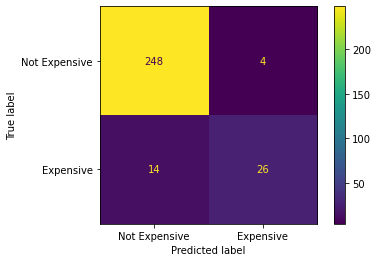

In [13]:
ConfusionMatrixDisplay.from_estimator(search, X_test, y_test, display_labels = ["Not Expensive", "Expensive"]);